# Estimation with Logicle Scale
In this notebook we use the implemented Logicle Scale to perform the parameter estimation for the simple conversion reaction model. Implementation can be found in the $\textit{LogicleScale.py}$ script.

In [28]:
import os
import importlib
import pandas as pd

import amici
import matplotlib.pyplot as plt
import numpy as np 
import petab 

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

from LogicleScale import    logicleTransform, \
                            logicleInverseTransform, \
                            function_parameters, \
                            logicleGradient, \
                            logicleInverseGradient

In [ ]:
model_name= "Spoegler_conversionReaction"
param_scale= "logicle" 

# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

# model properties
print("Model parameters:", list(model.getParameterIds()), "\n")
print("Model constant parameters:", list(model.getFixedParameterIds()), "\n")
print("Model outputs:    ", list(model.getObservableIds()), "\n")
print("Model states:     ", list(model.getStateIds()), "\n")

In [30]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()     

In [31]:
# linear objective function
obj_lin = importer.create_objective()

# shifted parameter
T= 1000
trans = 1e-5

def fun(x):
    return obj_lin.get_fval(logicleInverseTransform(scaled=x, T=T, trans=trans))

def grad(x):
    return obj_lin.get_grad(logicleInverseTransform(scaled=x, T=T, trans=trans)) * logicleInverseGradient(scaled=x, T=T, trans=trans)


# new objective function
obj = pypesto.Objective(fun=fun, grad=grad)

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/amici_models/Sp_gler_ConversionReaction.


In [32]:
obj_lin([0.2, 0.1, 0.0, 0.15])

-3.418410576784529

In [33]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', obj(petab_problem.x_nominal))

optimal x =  [0.18031863, 0.15425572, 0.0, 0.15425572]
optimal lh value 19.160988588870726


In [34]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(obj)

# do the optimization
n_starts = 100

result = optimize.minimize(
        problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None
)

 28%|██▊       | 28/100 [00:46<02:30,  2.09s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 43.3507, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 43.350743:
AMICI failed to integrate the forward problem

 31%|███       | 31/100 [00:48<01:34,  1.37s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 30.3057, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 30.305750:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 20.3888, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 20.388796:
AMICI failed to integrate the forward problem

 40%|████      | 40/100 [01:05<02:00,  2.00s/it][Warning] AMICI:CVODES:CV

best parameter:  [0.21633051 0.0781011  0.00268007 0.11355436]
best likelihood value:  -5.748130247202401


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

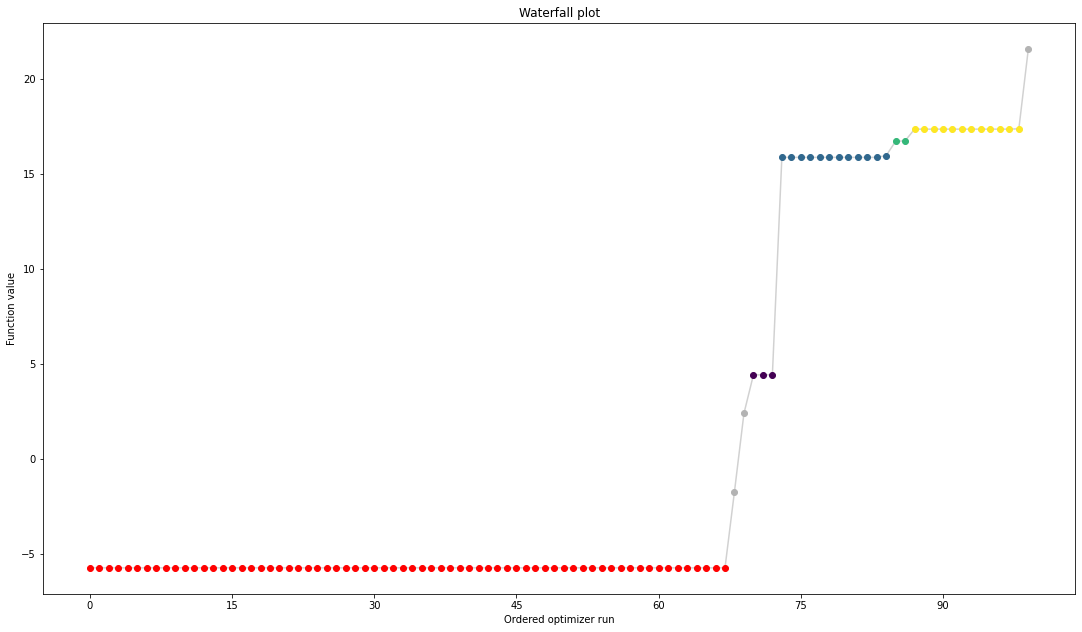

In [35]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', obj(best_result))

fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

In [36]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged)

Number of converged runs:  68


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

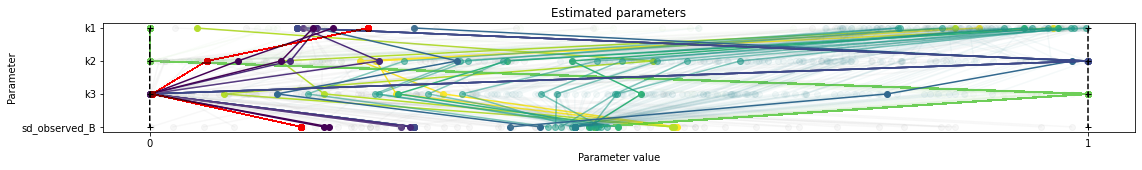

In [19]:
visualize.parameters(result)

In [37]:
results =   [['theta1',petab_problem.x_nominal[0], best_result[0], 0.2, logicleInverseTransform(best_result, T=T, trans=trans)[0], obj(petab_problem.x_nominal), obj(best_result)],
             ['theta2', petab_problem.x_nominal[1], best_result[1], 0.1, logicleInverseTransform(best_result, T=T, trans=trans)[1], obj(petab_problem.x_nominal), obj(best_result)],
             ['theta3', petab_problem.x_nominal[2], best_result[2], 0.0, logicleInverseTransform(best_result, T=T, trans=trans)[2], obj(petab_problem.x_nominal) , obj(best_result)],
             ['sigma', petab_problem.x_nominal[3], best_result[3], 0.15, logicleInverseTransform(best_result, T=T, trans=trans)[3], obj(petab_problem.x_nominal), obj(best_result)]]

results_df = pd.DataFrame(results, columns=['Parameter', 'Nominal', 'best', 'nominal-linear', 'best-linear', 'nominal-likelihood', 'likelihood'])

print(results_df)

results_df.to_csv("estimation_results/"+param_scale+".csv", index=False)

  Parameter   Nominal      best  nominal-linear  best-linear  \
0    theta1  0.180319  0.216331            0.20     0.294183   
1    theta2  0.154256  0.078101            0.10     0.056966   
2    theta3  0.000000  0.002680            0.00     0.001757   
3     sigma  0.154256  0.113554            0.15     0.092832   

   nominal-likelihood  likelihood  
0           19.160989    -5.74813  
1           19.160989    -5.74813  
2           19.160989    -5.74813  
3           19.160989    -5.74813  
